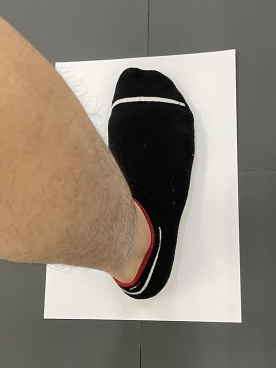

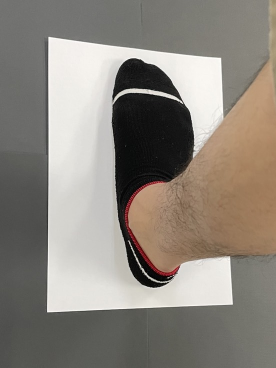

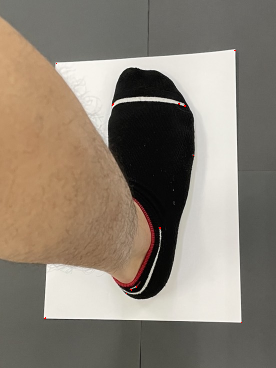

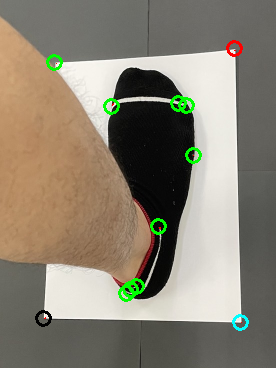

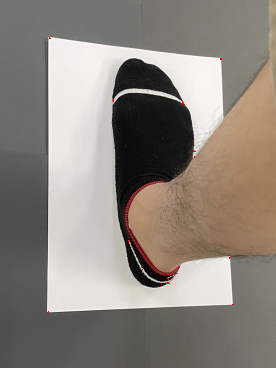

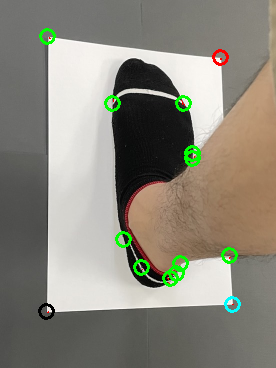

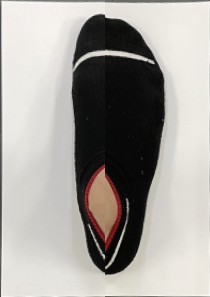

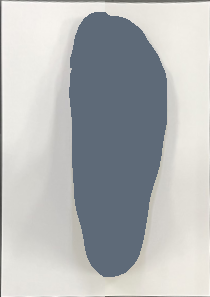

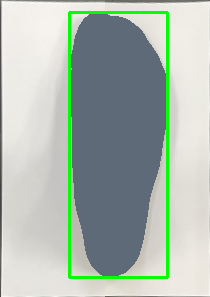

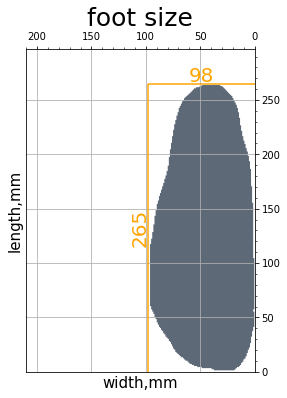

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from IPython.core.display import Image
from numpy.lib.function_base import append
import numpy as np
from google.colab.patches import cv2_imshow
import cv2 # 導入OpenCV函式庫
from google.colab import files
import matplotlib.pyplot as plt


# 剪裁4紙張區域=============================================================
def cut_ROI(img):
  cut_width = int(img.shape[1]/4)
  cut_height = int(img.shape[0]/4)
  img = img[cut_height:3*cut_height,cut_width:3*cut_width]
  cv2_imshow(img)
  return img
# ===========================================================================  

# ============================找A4四點=====================================
def findcorner(img):
  img_conrner = img.copy()
  gray = cv2.cvtColor(img_conrner, cv2.COLOR_BGR2GRAY)
  gray = np.float32(gray)
  dst = cv2.cornerHarris(gray,2,3,0.06)
  ret, dst = cv2.threshold(dst,0.05*dst.max(),255,0)
  dst = np.uint8(dst)
  ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
  corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

  four_corner = np.zeros((4,2))  #存放四點
  corner_point = np.zeros((len(corners)-1,2))#找到的轉角(不只四個)

  for i in range(1, len(corners)):  #將找到的點放入corner_point(corners第一個不放)
      # print(corners[i,0],corners[i,1])
      corner_point[i-1] = corners[i]
# 轉成整數找像素點=========================================================
# 排序(0,0)->(1,0)->(0,1)->(1,1)
  corner_point = corner_point.astype(int)
  corner_point[np.lexsort(corner_point.T)]
  four_corner[0] = corner_point[0]
  four_corner[1] = corner_point[1]
  four_corner[2] = corner_point[-1]
  four_corner[3] = corner_point[-2]
  # print(four_corner)
  if four_corner[0,0] > four_corner[1,0]:
    tmp = np.copy(four_corner[0])
    four_corner[0] = np.copy(four_corner[1])
    four_corner[1] = np.copy(tmp)
  if four_corner[2,0] > four_corner[3,0]:
    tmp = np.copy(four_corner[2])
    four_corner[2] = np.copy(four_corner[3])
    four_corner[3] = np.copy(tmp)
  # print(four_corner)
# 畫出四個角======================================================
  img_conrner[dst>0.05*dst.max()]=[0,0,255]
  cv2_imshow(img_conrner)

  for i in range(0, len(corner_point)):
      # print(corner_point[i,0])
      # print(corner_point[i,1])
      cv2.circle(img_conrner, (int(corner_point[i,0]), int(corner_point[i,1])), 7, (0,255,0), 2)
  cv2.circle(img_conrner, (int(four_corner[0,0]), int(four_corner[0,1])), 7, (0,255,0), 2)
  cv2.circle(img_conrner, (int(four_corner[1,0]), int(four_corner[1,1])), 7, (0,0,255), 2)
  cv2.circle(img_conrner, (int(four_corner[2,0]), int(four_corner[2,1])), 7, (0,0,0), 2)
  cv2.circle(img_conrner, (int(four_corner[3,0]), int(four_corner[3,1])), 7, (255,255,0), 2)
  cv2_imshow(img_conrner)
  # cv2.imwrite('img_conrner_point.jpg',img_conrner)
  return four_corner
# =========================================================================================

# ============================找出腳的輪廓及長寬並剪裁===========================================
def find_and_cut_foot_edge(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # cv2_imshow(gray)
  blurred = cv2.GaussianBlur(gray, (11, 11), 0)
  # cv2_imshow(blurred)
  edged = cv2.Canny(blurred, 150, 300)
  # cv2_imshow(edged)
  edged = cv2.dilate(edged, np.ones((5, 5)))
  # cv2_imshow(edged)
  contours, hierarchy = cv2.findContours(edged.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # print(len(contours))
  # cv2_imshow(edged)
  image_edge = image.copy()
  cv2.drawContours(image_edge, contours, -1, (120, 106, 94), -1)
  cv2_imshow(image_edge)


  x,y,w,h = cv2.boundingRect(contours[0])
  # print(x,y,w,h)
  cv2.rectangle(image_edge,(x,y),(x+w,y+h),(0,255,0),2)
  cv2_imshow(image_edge)
  mask = np.zeros(gray.shape, dtype='uint8')  #依Contours圖形建立mask
  cv2.drawContours(mask, contours, -1,255, -1) #255 
  # cv2_imshow(mask)
  edge_out = cv2.bitwise_and(image_edge, image_edge, mask=mask)
  edge_out = edge_out[y:y+h,x:x+w]

  black_bg = np.zeros([h,w,3], dtype='uint8')
  white_bg = ~black_bg

  result = white_bg+edge_out
  # cv2_imshow(result)
  return result ,w,h

# =========================================================================================

# ===========================畫出圖片並且儲存===================================
def foot_size_print_and_save(img,w,h):
  plt.figure(figsize=(width/2.5/20,height/2.5/20))
  ax = plt.axes()
  plt.gca()
  plt.xlim(0,width)
  plt.ylim(0,height)

  plt.title('foot size', fontsize=25)
  plt.xlabel('width,mm', fontsize=15)
  plt.ylabel('length,mm', fontsize=15)

  ax.invert_xaxis()
  ax.xaxis.tick_top()
  ax.yaxis.tick_right()
  ax.grid()
  plt.minorticks_on()
  # print(x,y,w,h)
  plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  plt.hlines(h,0,w,color="orange")
  plt.vlines(w,0,h,color="orange")
  plt.text(w/2, h+2, w, fontsize=20, color='orange', horizontalalignment ='center')
  plt.text(w+2, h/2, h, fontsize=20, color='orange',horizontalalignment ='center',rotation=90,rotation_mode='anchor')
  plt.savefig('M11012002.jpg')
  plt.show()
# =========================================================================================


# 1. Able to read/import images.
right_foot = cv2.imread('right_foot.jpg')
left_foot = cv2.imread('left_foot.jpg')
right_foot = cv2.resize(right_foot,(int(right_foot.shape[1]/2),int(right_foot.shape[0]/2)))
left_foot = cv2.resize(left_foot,(int(left_foot.shape[1]/2),int(left_foot.shape[0]/2)))
height ,width = 297,210 #A4紙長寬

# 如果圖片只包含A4及少許背景不用執行此區============================================================
right_foot = cut_ROI(right_foot)
left_foot = cut_ROI(left_foot)
# =========================================================================================

# 2. Able to determine the corns on the A4 sheet.
right_foot_corner = findcorner(right_foot)
left_foot_corner = findcorner(left_foot)

# 3. Able to convert both images into an orthogonal view (a synthesized TOP view).

pts_dst = np.array([[0, 0],[210-1, 0],[0, 297-1],[210-1, 297-1]])

pts_dst_right = np.array([[210/2, 0],[210/2, 297-1],[210-1, 297-1],[210-1, 0]])
pts_dst_right = pts_dst_right.astype(int)

pts_dst_left = np.array([[0, 0],[0, 297-1],[(210/2)-1, 297-1],[(210/2)-1, 0]])
pts_dst_left = pts_dst_left.astype(int)

hr ,status= cv2.findHomography(right_foot_corner, pts_dst)
hl ,status= cv2.findHomography(left_foot_corner, pts_dst)


im_out_right = cv2.warpPerspective(right_foot, hr, (width,height))
im_out_left = cv2.warpPerspective(left_foot, hl, (width,height))

size = (height,width)
# left_region
mask_left = np.zeros(size, np.uint8)
cv2.fillPoly(mask_left, [pts_dst_left], (255), 8, 0)
im_left = cv2.bitwise_and(im_out_left, im_out_left, mask=mask_left)
# cv2_imshow(im_left)

# # right_region
mask_right = np.zeros(size, np.uint8)
cv2.fillPoly(mask_right, [pts_dst_right], (255), 8, 0)
im_right = cv2.bitwise_and(im_out_right, im_out_right, mask=mask_right)
# cv2_imshow(im_right)

img_merge = im_left + im_right
cv2_imshow(img_merge)


# 4. Able to draw short text on the image to report the width and length of the foot.
# 5. Save the result image as your_ID.jpg.
result,w,h = find_and_cut_foot_edge(img_merge)
foot_size_print_and_save(result,w,h)
files.download("M11012002.jpg")
